In [1]:
!nvidia-smi 

Mon Apr 20 07:16:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import glob 

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cv2
from sklearn.preprocessing import scale

In [3]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
paths = glob.glob('./drive/My Drive/Dataset/Dataset_lab_2/VisDrone2019-DET-val/images/*.jpg')
ssd_model.to('cuda')
ssd_model.eval()
print(f'Image count - {len(paths)}')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Image count - 548


In [4]:
import inspect

print(inspect.getsource(utils.prepare_input))

        @staticmethod
        def prepare_input(img_uri):
            img = Processing.load_image(img_uri)
            img = Processing.rescale(img, 300, 300)
            img = Processing.crop_center(img, 300, 300)
            img = Processing.normalize(img)
            return img



Because prepare function crop image center, some bboxes will be deleted

In [0]:
txt_paths = glob.glob('./drive/My Drive/Dataset/Dataset_lab_2/VisDrone2019-DET-val/annotations/*.txt')

In [0]:
BASE_IMAGE = "./drive/My Drive/Dataset/Dataset_lab_2/VisDrone2019-DET-val/images/"
BASE_ANNOTATION = "./drive/My Drive/Dataset/Dataset_lab_2/VisDrone2019-DET-val/annotations/"

In [0]:
classes ={0 :'ignored regions',
          1 :'pedestrian',
          2 :'people',
          3 :'bicycle',
          4 :'car',
          5 :'van',
          6 :'truck',
          7 :'tricycle',
          8 :'awning-tricycle',
          9 :'bus',
          10 :'motor',
          11 :'others'}

In [0]:
translate_classes ={0 : None,
                    1 :1,
                    2 :1,
                    3 :2,
                    4 :3,
                    5 :None,
                    6 :8,
                    7 :None,
                    8 :None,
                    9 :6,
                    10 :4,
                    11 :None}

In [0]:
def parse_annotations(txt_paths):
    columns = ['bbox_left', 'bbox_top', 'bbox_width', 'bbox_height', 'score', 'object_category', 'truncation', 'occlusion']
    meta_data = pd.DataFrame(columns=columns)
    meta_data['height'] = None
    meta_data['width'] = None

    for txt_path in txt_paths:
        df = pd.read_csv(txt_path, names=columns)
        img_name = txt_path.split('/')[-1].split('.')[0]
        df.index = [img_name]*len(df)
        im = cv2.imread(BASE_IMAGE + img_name + '.jpg')
        height, width, _ = im.shape
        df['height'] = height
        df['width'] = width
        meta_data = meta_data.append(df)
    return meta_data

In [0]:
%%time
meta_data = parse_annotations(txt_paths)
meta_data.to_csv('meta_data.csv')

CPU times: user 10.4 s, sys: 565 ms, total: 10.9 s
Wall time: 11min 15s


In [9]:
meta_data = pd.read_csv('meta_data.csv', index_col='id')
meta_data.index = meta_data.index.astype(str)
meta_data

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,height,width
id,,,,,,,,,,
0000291_02601_d_0000881,1075,22,20,18,1,4,0,0,765,1360
0000291_02601_d_0000881,1002,111,25,25,1,4,0,0,765,1360
0000291_02601_d_0000881,1118,117,57,26,1,4,0,0,765,1360
0000291_02601_d_0000881,1008,191,56,26,1,4,0,0,765,1360
0000291_02601_d_0000881,1019,212,82,47,1,4,0,0,765,1360
...,...,...,...,...,...,...,...,...,...,...
0000290_04001_d_0000867,965,608,114,52,1,4,0,1,765,1360
0000290_04001_d_0000867,1337,652,23,38,1,3,1,0,765,1360
0000290_04001_d_0000867,1183,60,43,25,1,6,0,1,765,1360


In [0]:
def rescale(s):
    n_w = [(s.width - s.height)/2, (s.height + s.width)/2]
    if s.bbox_left < n_w[0] or s.bbox_left + s.bbox_width < n_w[0] or s.bbox_left > n_w[1] or s.bbox_left + s.bbox_width > n_w[1]:
        s.bbox_left = None
        s.bbox_top = None
        s.bbox_width = None
        s.bbox_height = None
    else:
        s.bbox_left = (s.bbox_left - n_w[0]) * 300 / s.height
        s.bbox_top = s.bbox_top  * 300 / s.height
        s.bbox_width = s.bbox_width * 300 / s.height
        s.bbox_height = s.bbox_height * 300 / s.height
    
    return s

In [11]:
%%time
meta_data_rescaled = meta_data.apply(rescale, axis=1)

CPU times: user 20.2 s, sys: 57.7 ms, total: 20.3 s
Wall time: 20.3 s


In [12]:
print(f"Croped bboxes - {meta_data_rescaled.bbox_left.isna().sum()}")
meta_data_rescaled = meta_data_rescaled.dropna()

Croped bboxes - 10418


In [13]:
meta_data_rescaled.object_category = meta_data_rescaled.object_category.replace(translate_classes)
print(f"Unknown classes - {meta_data_rescaled.object_category.isna().sum()}")
meta_data_rescaled = meta_data_rescaled.dropna()

Unknown classes - 3787


In [15]:
print(f"Image count - {len(meta_data_rescaled.index.unique())}")

Image count - 545


In [16]:
classes_to_labels = utils.get_coco_object_dictionary()

In [0]:
inputs = [utils.prepare_input(path) for path in paths]

In [0]:
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [0]:
batchs = []
results = []

for i in np.arange(0, 548):
    with torch.no_grad():
        detections_batch = ssd_model(tensor[i:i+1])
        batchs.append(detections_batch)
        try:
            results_per_input = utils.decode_results(detections_batch)
        except RuntimeError:
            print(f'Failed to load {i}')
        best_results_per_input = [utils.pick_best(results, 0.30) for results in results_per_input]
        results.append(best_results_per_input)

In [0]:
def iou(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [21]:
final_result = []
idx = 0 
for result in results:
    image = paths[idx].split('/')[-1].split('.')[0]
    idx+=1
    if image not in meta_data_rescaled.index:
        print(f"Skip image - {image}")
        continue
    meta_data_rescaled.loc[image]
    result_bboxes = result[0][0] * 300
    result_classes = result[0][1]
    confidences = result[0][2]
    true_boxes = meta_data_rescaled.loc[image][['bbox_left', 'bbox_top', 'bbox_width', 'bbox_height']].values
    true_classes = meta_data_rescaled.loc[image][['object_category']].values
    if len(true_classes) == 1:
        true_boxes = [true_boxes]
    for true_idx in range(len(true_classes)):
        for result_idx in range(len(result_classes)):
            if true_classes[true_idx] == result_classes[result_idx]:
                IoU = iou(result_bboxes[result_idx], [true_boxes[true_idx][0],
                                                    true_boxes[true_idx][1] ,
                                                    true_boxes[true_idx][0] + true_boxes[true_idx][2],
                                                    true_boxes[true_idx][1] + true_boxes[true_idx][3]])
            else:
                IoU = 0
            final_result.append([idx, image,true_classes[true_idx], IoU, result_bboxes[result_idx], true_boxes[true_idx]])

    


Skip image - 0000242_00843_d_0000004
Skip image - 0000103_04948_d_0000035
Skip image - 0000103_03738_d_0000032


In [0]:
df = pd.DataFrame(final_result, columns=['id', 'image', 'clas', 'iou', 'output_bboxes', 'true_bboxes'])
df.true_bboxes = df.true_bboxes.astype(str)
gropby_true = df.groupby('true_bboxes')['iou'].max()

In [0]:
def f(s):
    try :
        return s[0]
    except IndexError:
        return s

df.clas = df.clas.apply(f)

In [0]:
groupby_classes = df.groupby(['clas', 'true_bboxes'], as_index=False).count()
num_by_classes = groupby_classes.groupby('clas')['output_bboxes'].sum()

In [0]:
df.loc[df.iou > 0.5].groupby(['clas', 'true_bboxes'], as_index=False).count().groupby('clas')['output_bboxes'].sum()

clas
1.0     247
2.0       1
3.0    1280
4.0       3
6.0      10
8.0      28
Name: output_bboxes, dtype: int64

In [0]:
## Base
task_3_1 = []
task_3_2 = []
for alpha in [0, 0.5, 0.75, 0.9]:
    false = gropby_true.loc[gropby_true < alpha].count()
    accuracy = gropby_true.loc[gropby_true > alpha].count() / len(gropby_true)
    task_3_1.append([false, accuracy])

    false = df.loc[df.iou < alpha].groupby(['clas', 'true_bboxes'], as_index=False).count().groupby('clas')['output_bboxes'].sum()
    accuracy = df.loc[df.iou > alpha].groupby(['clas', 'true_bboxes'],
                                            as_index=False).count().groupby('clas')['output_bboxes'].sum()\
                                            / num_by_classes
    task_3_2.append([false, accuracy, alpha])




In [38]:
r1 = pd.DataFrame(task_3_1, index=[0, 0.5, 0.75, 0.9], columns=['false', 'accuracy'])
r1.index.name = 'alpha'
r1

,false,accuracy
alpha,,
0.00,0,0.217127
0.50,21766,0.067118
0.75,22360,0.041660
0.90,23207,0.005357


In [0]:
r2 = pd.DataFrame(columns=['alpha', 'class', 'accuracy', 'false' ])
for result in task_3_2:
    alpha = result[2]
    classes = result[1].index
    accuracy = result[0].values
    false = result[1].values
    for idx in range(len(accuracy)):
        if len(false) == 0:
            r2 = r2.append({'alpha': alpha, 'class': classes[idx], 'accuracy':accuracy[idx], 'false':0}, ignore_index=True)
        else:
            r2 = r2.append({'alpha': alpha, 'class': classes[idx], 'accuracy':accuracy[idx], 'false':false[idx]}, ignore_index=True)

In [58]:
r2 = r2.fillna(0)
r2

,alpha,class,accuracy,false
0,0.50,1.0,52120.0,0.004717
1,0.50,2.0,4809.0,0.000208
2,0.50,3.0,59006.0,0.021232
3,0.50,4.0,15752.0,0.000190
4,0.50,6.0,1178.0,0.008418
5,0.50,8.0,2024.0,0.013645
6,0.75,1.0,52292.0,0.001432
7,0.75,2.0,4810.0,0.000000
8,0.75,3.0,59422.0,0.014332
9,0.75,4.0,15755.0,0.000000


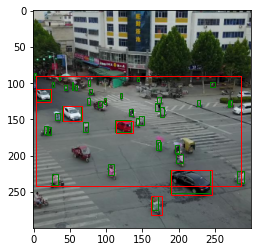

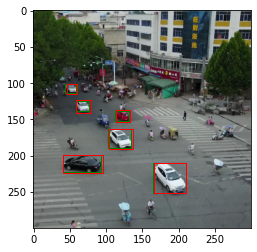

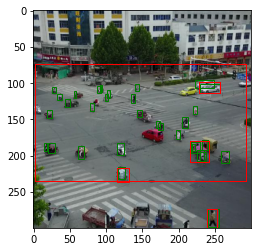

In [100]:
images = ['0000193_01705_d_0000112', '0000193_01876_d_0000113', '0000193_01497_d_0000111']
image_idx = [0, 546, 547]

for idx in range(len(image_idx)):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx[idx]] / 2 + 0.5
    ax.imshow(image)
    output_bboxes = df[(df.image == images[idx]) & (df.iou > 0)].output_bboxes
    true_bboxes = df[(df.image == images[idx]) & (df.iou > 0)].true_bboxes
    for bbox_id in range(len(true_bboxes)):
        x, y, w, h = true_bboxes.iloc[bbox_id]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for bbox_id in range(len(output_bboxes)):
        left, bot, right, top = output_bboxes.iloc[bbox_id]
        x, y, w, h = [left, bot, right - left, top - bot]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    

plt.show()